In [1]:
from mflex.model.field.bfield_model import (
    magnetic_field,
    magnetic_field_hypergeo,
    magnetic_field_low,
)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mflex.simulate.simulate_boundary import dipole
from mflex.plot.plot_magnetogram import plot_fieldlines_polar_thesis
from mflex.evaluate.metrics import (
    vec_corr_metric,
    vec_corr_metric2,
    cau_Schw_metric,
    cau_Schw_metric2,
    norm_vec_err_metric,
    norm_vec_err_metric2,
    mean_vec_err_metric,
    mean_vec_err_metric2,
    mag_ener_metric,
    mag_ener_metric2,
    field_div_metric,
    pearson_corr_coeff_comp,
)
from mflex.model.plasma_parameters import (
    bpressure,
    bdensity,
    btemp,
    deltapres,
    deltaden,
    pres,
    den,
    btemp,
)

In [2]:
xmin = 0.0
ymin = 0.0
zmin = 0.0
xmax = 2.0
ymax = 2.0
zmax = 2.0

nresol_x = 200
nresol_y = 200
nresol_z = 400
nf_max = 200

pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 0.2
deltaz = 0.02

length_scale = 1.0
length_scale_x = 1.0 * nresol_x * float(pixelsize_x)
length_scale_y = 1.0 * nresol_y * float(pixelsize_y)
length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin

In [10]:
t_photosphere = 5600.0
t_corona = 2.0 * 10.0**6
t0 = (t_photosphere + t_corona * np.tanh(z0 / deltaz)) / (1.0 + np.tanh(z0 / deltaz))
t1 = (t_corona - t_photosphere) / (1.0 + np.tanh(z0 / deltaz))
L = 1.0
g_solar = 272.2  # kg/m^3
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
h = (
    kB * t0 / (mbar * g_solar) * 10**-6 / L  # h' = h / L
)  # pressure scale height in normalised length scale (10**-6 to convert to Mm, and L**-1 to convert to normalised length scale)
rho0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
b0 = 500.0  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4) ** 2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
h_photo = h / t0 * t_photosphere
print(b0, pB0, p0, beta0)

500.0 994.7183954609776 12480.666786239555 12.546934733679777


In [3]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["dimgray", "whitesmoke"]
)

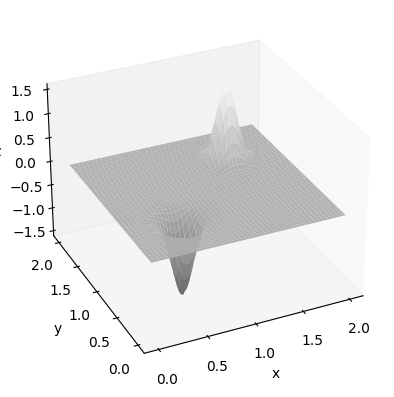

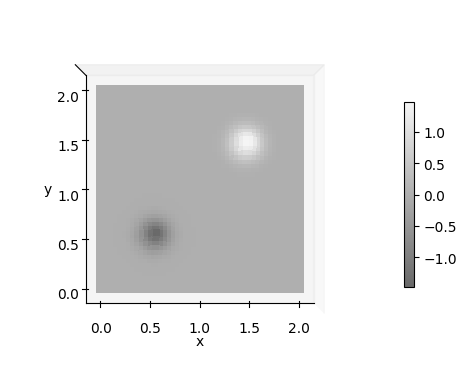

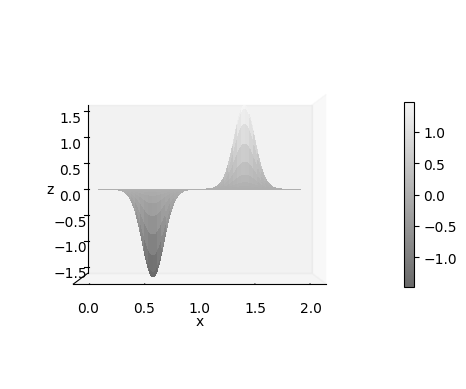

In [4]:
data_bz = np.zeros((nresol_y, nresol_x))

x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_surface(y_plot, x_plot, data_bz, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.view_init(30, -115, 0)
ax.grid(False)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_surface1.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
cs = ax.plot_surface(y_plot, x_plot, data_bz, cmap=cmap, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.view_init(90, -90, 0)
ax.grid(False)
ax.set_zticks([])
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_surface2.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
cs = ax.plot_surface(y_plot, x_plot, data_bz, cmap=cmap, antialiased=False)
ax.set_xlabel("x")
ax.set_zlabel("z")
ax.view_init(0, -90, 0)
ax.grid(False)
ax.set_yticks([])
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_surface3.png"
plt.savefig(plotname, dpi=300)
plt.show()

In [13]:
# Height profile f parameters
a = 0.44
alpha = 0.25
b = 1.0

# Magnitc field parameters
z0_b = 0.2
deltaz_b = 0.02
"""a_low = a * (1 - np.tanh(-z0_b / deltaz_b))
kappa = 2.0 / deltaz_b
kappa = -np.log(a/a_low)/z0"""

h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

mfield_hyp, dmfield_hyp = magnetic_field_hypergeo(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)
mfield_asymp, dmfield_asymp = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)
# """mfield_low, dmfield_low = magnetic_field_low(
#     data_bz,
#     z0_b,
#     kappa,
#     a_low,
#     b,
#     alpha,
#     xmin,
#     xmax,
#     ymin,
#     ymax,
#     zmin,
#     zmax,
#     nresol_x,
#     nresol_y,
#     nresol_z,
#     pixelsize_x,
#     pixelsize_y,
#     nf_max,
#     length_scale,
# )"""

print(
    "Field line",
    field_div_metric(
        mfield_hyp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)
print(
    "Ref",
    field_div_metric(
        mfield_asymp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)

length scale 2.0
length scale x 4.0
length scale y 4.0
length scale x norm 2.0
length scale y norm 2.0
xmin, xmax, ymin, ymax, zmin, zmax  0.0 2.0 0.0 2.0 0.0 2.0


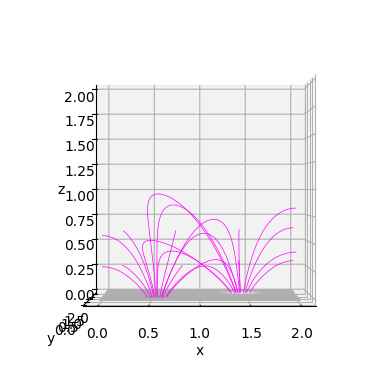

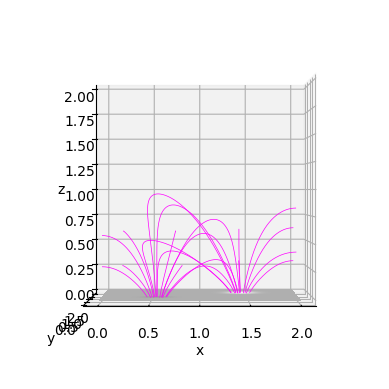

In [48]:
plot_fieldlines_polar_thesis(
    mfield_hyp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_hyp",
    cmap=cmap,
)

plot_fieldlines_polar_thesis(
    mfield_asymp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_asymp",
    cmap=cmap,
)

In [15]:
bfield_bx_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

bfield_bx_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

B_rec = np.array((bfield_by_rec, bfield_bx_rec, bfield_bz_rec))
B_ref = np.array((bfield_by_ref, bfield_bx_ref, bfield_bz_ref))

print("Vec Corr", vec_corr_metric(B_ref, B_rec))
print("Ref", vec_corr_metric(B_ref, B_ref))
print("Vec Corr2", vec_corr_metric2(B_ref, B_rec))
print("Ref", vec_corr_metric2(B_ref, B_ref))
print("Cau Schw", cau_Schw_metric(B_ref, B_rec))
print("Ref", cau_Schw_metric(B_ref, B_ref))
print("Cau Schw2", cau_Schw_metric2(B_ref, B_rec))
print("Ref", cau_Schw_metric2(B_ref, B_ref))
print("Norm err", norm_vec_err_metric(B_ref, B_rec))
print("Ref", norm_vec_err_metric(B_ref, B_ref))
print("Norm err2", norm_vec_err_metric2(B_ref, B_rec))
print("Ref", norm_vec_err_metric2(B_ref, B_ref))
print("Mean err", mean_vec_err_metric(B_ref, B_rec))
print("Ref", mean_vec_err_metric(B_ref, B_ref))
print("Mean err2", mean_vec_err_metric2(B_ref, B_rec))
print("Ref", mean_vec_err_metric2(B_ref, B_ref))
print("Mag ener", mag_ener_metric(B_ref, B_rec))
print("Ref", mag_ener_metric(B_ref, B_ref))
print("Mag ener2", mag_ener_metric2(B_ref, B_rec))
print("Ref", mag_ener_metric2(B_ref, B_ref))

Vec Corr 0.9999864578823289
Ref 1.0
Vec Corr2 0.9999864578825034
Ref 1.0
Cau Schw 0.9999748333333334
Ref 1.0
Cau Schw2 0.9999996579541601
Ref 1.0
Norm err 0.0022335378677368106
Ref 0.0
Norm err2 0.002274094490255164
Ref 0.0
Mean err 0.0009432002487844972
Ref 0.0
Mean err2 0.0006126601944483257
Ref 0.0
Mag ener 1.0000532504509425
Ref 1.0
Mag ener2 0.9981792190701668
Ref 1.0


In [16]:
dpres_hyp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))
dpres_asymp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))
# dpres_low = np.zeros((nresol_y, nresol_x, nresol_z))

dden_hyp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))
dden_asymp_mhs2 = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_low = np.zeros((nresol_y, nresol_x, nresol_z))

for ix in range(nresol_x):
    for iy in range(nresol_y):
        for iz in range(nresol_z):
            z = z_arr[iz]
            bz_hyp = mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            bz_asymp = mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            # bz_low = mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]

            dbz_hyp = (
                dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            dbz_asymp = (
                dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            """dbz_low = (
                dmfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
            )"""

            dpres_hyp_mhs2[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_hyp)
            dpres_asymp_mhs2[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_asymp)
            # dpres_low[iy, ix, iz] = deltapres_low(z, kappa, a, bz_low)

            dden_hyp_mhs2[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_hyp, dbz_hyp
            )
            dden_asymp_mhs2[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_asymp, dbz_asymp
            )
            # dden_low[iy, ix, iz] = deltaden_low(z, kappa, a, bz_low, dbz_low)

Pearson Correlation reference value for pressure PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation reference value for density PearsonRResult(statistic=0.9999999999999907, pvalue=0.0)
Pearson Correlation actual value for pressure PearsonRResult(statistic=0.9999993764018529, pvalue=0.0)
Pearson Correlation actual value for density PearsonRResult(statistic=0.9999999631453668, pvalue=0.0)


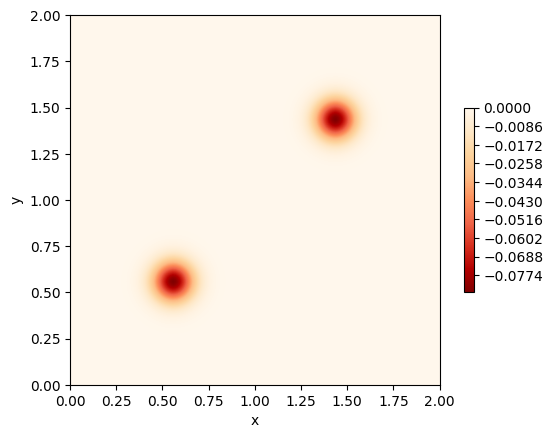

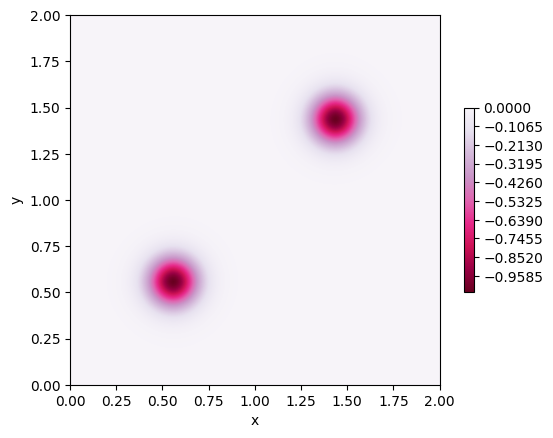

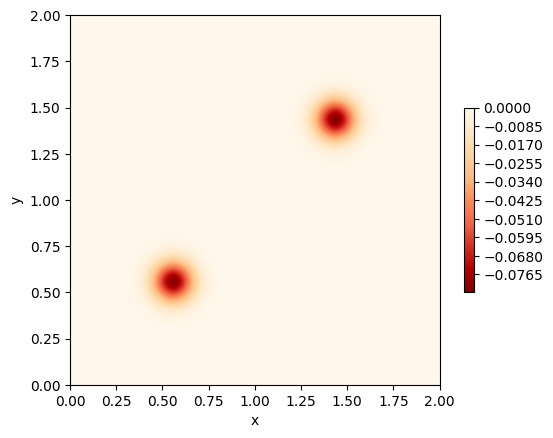

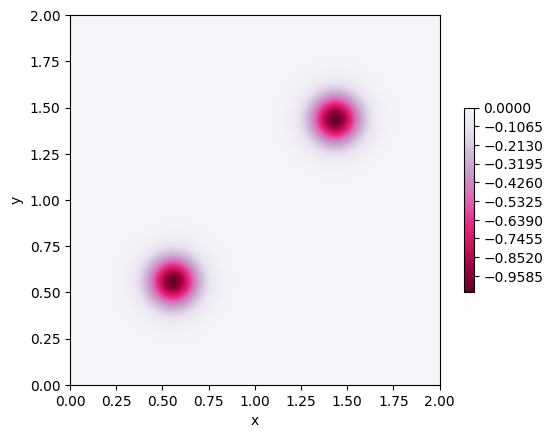

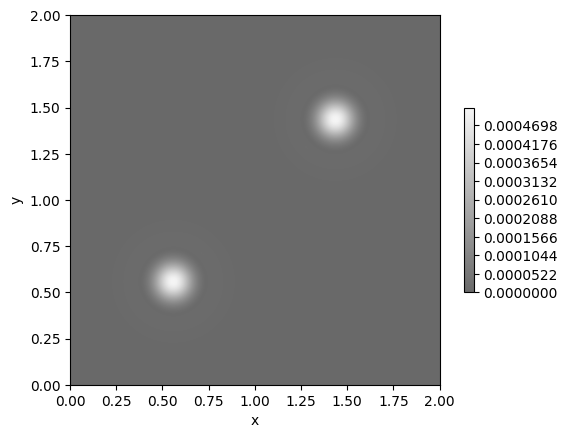

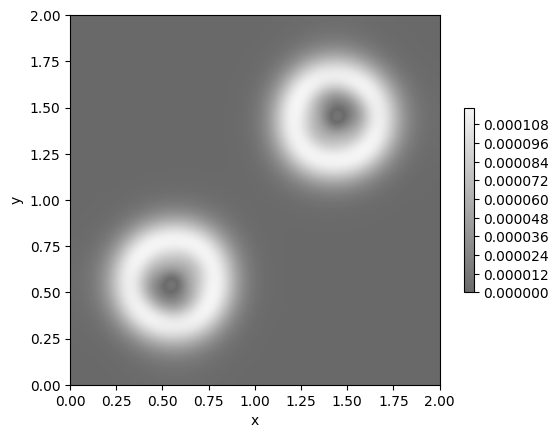

Max diff p 0.0005199999903486435
Max diff d 0.00011871333834137521


In [49]:
pres_surface_ref, den_surface_ref, pres_surface_rec, den_surface_rec = (
    pearson_corr_coeff_comp(
        dpres_asymp_mhs2,
        dden_asymp_mhs2,
        dpres_hyp_mhs2,
        dden_hyp_mhs2,
        nresol_x,
        nresol_y,
        nresol_z,
        zmin,
        zmax,
    )
)

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, pres_surface_ref, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs2_fp_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, den_surface_ref, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs2_fd_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, pres_surface_rec, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs2_fp_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, den_surface_rec, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs2_fd_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, abs(pres_surface_rec - pres_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs2_fp_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, abs(den_surface_rec - den_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs2_fd_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

error_d = abs(den_surface_rec - den_surface_ref)
error_p = abs(pres_surface_rec - pres_surface_ref)

print("Max diff p", error_p.max())
print("Max diff d", error_d.max())

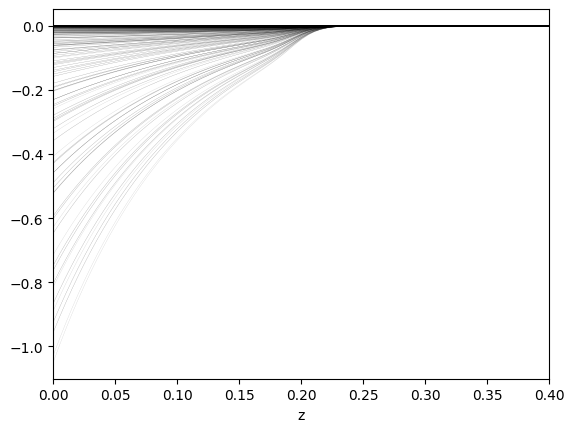

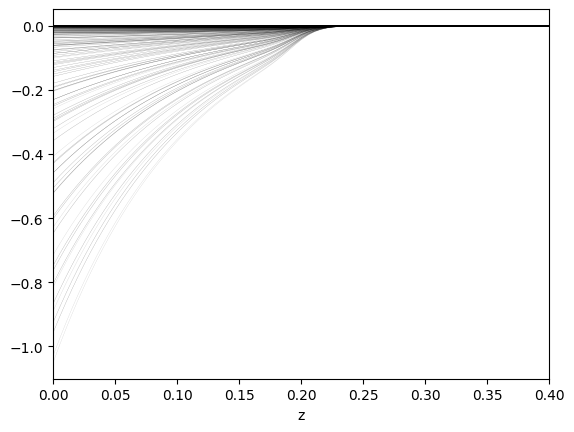

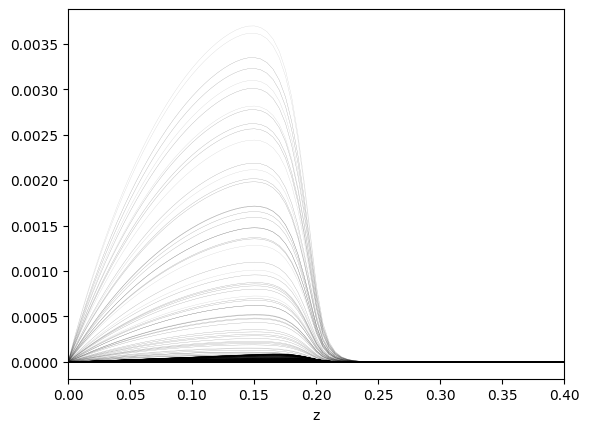

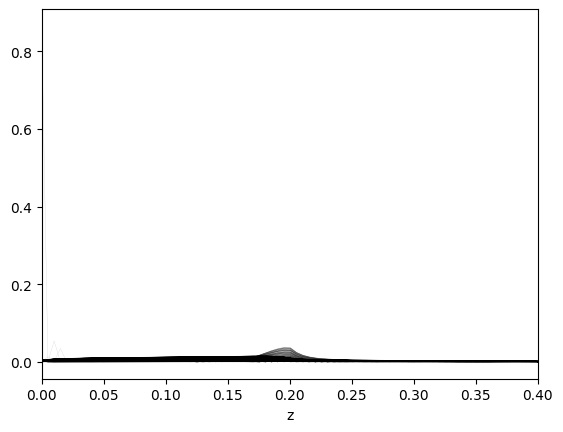

In [50]:
for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dpres_hyp_mhs2[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dphyp_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dpres_asymp_mhs2[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dpasymp_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

"""for ix in range(0, nresol_x, 1):
    for iy in range(0, nresol_y, 1):
        plt.plot(
            z_arr, dpres_low[iy, ix, :], linewidth=0.2, color="black", alpha=0.02
        )
plt.xlim([0, 2*z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dplow_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()"""

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dpres_hyp_mhs2[iy, ix, :] - dpres_asymp_mhs2[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dperr_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dden_hyp_mhs2[iy, ix, :] - dden_asymp_mhs2[iy, ix, :])
            / abs(dden_hyp_mhs2[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dperrrel_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

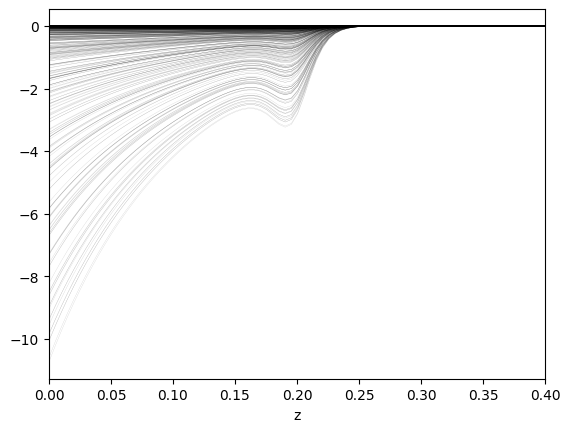

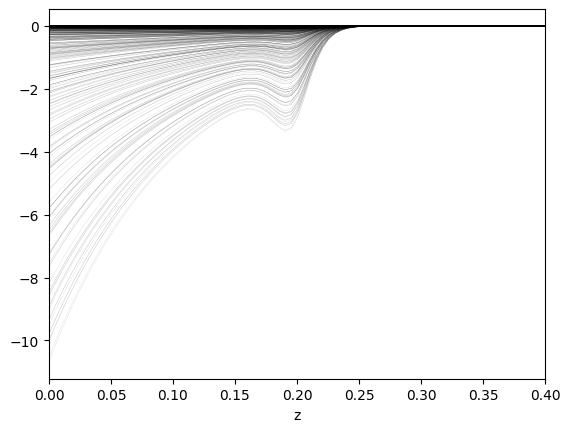

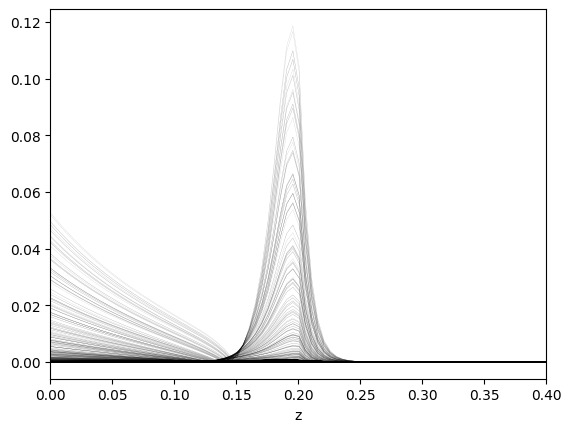

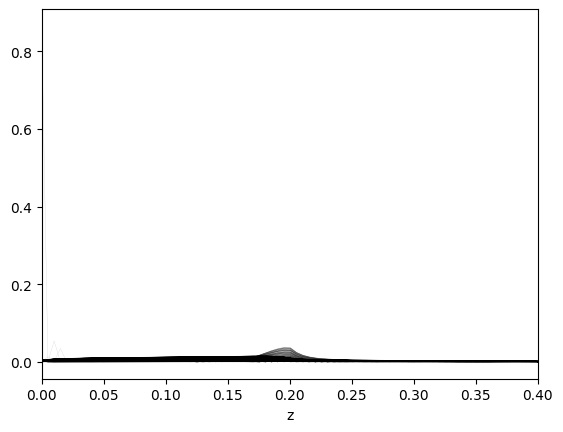

In [51]:
for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dden_hyp_mhs2[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_ddhyp_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dden_asymp_mhs2[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_ddasymp_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

"""for ix in range(0, nresol_x, 1):
    for iy in range(0, nresol_y, 1):
        plt.plot(
            z_arr, dden_low[iy, ix, :], linewidth=0.2, color="black", alpha=0.02
        )
plt.xlim([0, 2*z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_ddlow_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()"""

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dden_hyp_mhs2[iy, ix, :] - dden_asymp_mhs2[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dderr_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dden_hyp_mhs2[iy, ix, :] - dden_asymp_mhs2[iy, ix, :])
            / abs(dden_hyp_mhs2[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dderrrel_mhs2.png"
plt.savefig(plotname, dpi=300)
plt.show()

In [24]:
# Height profile f parameters
a = 0.22
alpha = 0.25
b = 1.0

# Magnitc field parameters
z0_b = 0.2
deltaz_b = 0.02
# a_low = a * (1 - np.tanh(-z0_b / deltaz_b))
# kappa = 2.0 / deltaz_b

mfield_hyp, dmfield_hyp = magnetic_field_hypergeo(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)
mfield_asymp, dmfield_asymp = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)
"""mfield_low, dmfield_low = magnetic_field_low(
    data_bz,
    z0_b,
    kappa,
    a_low,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)"""

print(
    "Field line",
    field_div_metric(
        mfield_hyp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)
print(
    "Ref",
    field_div_metric(
        mfield_asymp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)

length scale 2.0
length scale x 4.0
length scale y 4.0
length scale x norm 2.0
length scale y norm 2.0
xmin, xmax, ymin, ymax, zmin, zmax  0.0 2.0 0.0 2.0 0.0 2.0


/Users/lilli/Desktop/mflex/mflex/evaluate/metrics.py:395: RuntimeWarning: invalid value encountered in scalar divide
  temp = num / div


Field line 0.990990990990991
Ref 0.990990990990991


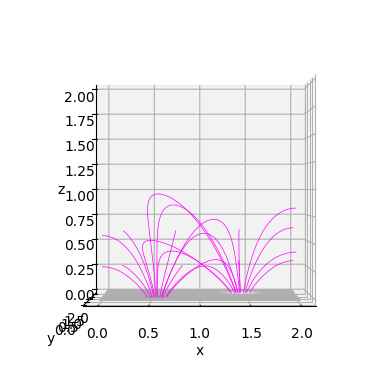

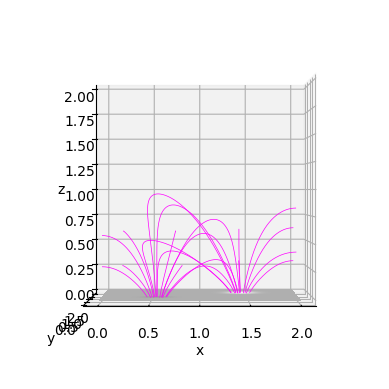

In [52]:
h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

plot_fieldlines_polar_thesis(
    mfield_hyp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_hyp",
    cmap=cmap,
)

plot_fieldlines_polar_thesis(
    mfield_asymp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_asymp",
    cmap=cmap,
)

In [26]:
bfield_bx_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

bfield_bx_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

B_rec = np.array((bfield_by_rec, bfield_bx_rec, bfield_bz_rec))
B_ref = np.array((bfield_by_ref, bfield_bx_ref, bfield_bz_ref))

print("Vec Corr", vec_corr_metric(B_ref, B_rec))
print("Ref", vec_corr_metric(B_ref, B_ref))
print("Vec Corr2", vec_corr_metric2(B_ref, B_rec))
print("Ref", vec_corr_metric2(B_ref, B_ref))
print("Cau Schw", cau_Schw_metric(B_ref, B_rec))
print("Ref", cau_Schw_metric(B_ref, B_ref))
print("Cau Schw2", cau_Schw_metric2(B_ref, B_rec))
print("Ref", cau_Schw_metric2(B_ref, B_ref))
print("Norm err", norm_vec_err_metric(B_ref, B_rec))
print("Ref", norm_vec_err_metric(B_ref, B_ref))
print("Norm err2", norm_vec_err_metric2(B_ref, B_rec))
print("Ref", norm_vec_err_metric2(B_ref, B_ref))
print("Mean err", mean_vec_err_metric(B_ref, B_rec))
print("Ref", mean_vec_err_metric(B_ref, B_ref))
print("Mean err2", mean_vec_err_metric2(B_ref, B_rec))
print("Ref", mean_vec_err_metric2(B_ref, B_ref))
print("Mag ener", mag_ener_metric(B_ref, B_rec))
print("Ref", mag_ener_metric(B_ref, B_ref))
print("Mag ener2", mag_ener_metric2(B_ref, B_rec))
print("Ref", mag_ener_metric2(B_ref, B_ref))

Vec Corr 0.9999986309597726
Ref 1.0
Vec Corr2 0.9999986309597867
Ref 1.0
Cau Schw 0.9999892916666666
Ref 1.0
Cau Schw2 0.9999999370334497
Ref 1.0
Norm err 0.0007772884980495899
Ref 0.0
Norm err2 0.0008072802663301021
Ref 0.0
Mean err 0.00045312165995986916
Ref 0.0
Mean err2 0.00029700833591164277
Ref 0.0
Mag ener 0.9997217745191848
Ref 1.0
Mag ener2 0.9998170764969584
Ref 1.0


In [27]:
dpres_hyp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))
dpres_asymp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))
# dpres_low = np.zeros((nresol_y, nresol_x, nresol_z))

dden_hyp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))
dden_asymp_mhs1 = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_low = np.zeros((nresol_y, nresol_x, nresol_z))

for ix in range(nresol_x):
    for iy in range(nresol_y):
        for iz in range(nresol_z):
            z = z_arr[iz]
            bz_hyp = mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            bz_asymp = mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            # bz_low = mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]

            dbz_hyp = (
                dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            dbz_asymp = (
                dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            """dbz_low = (
                dmfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
            )"""

            dpres_hyp_mhs1[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_hyp)
            dpres_asymp_mhs1[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_asymp)
            # dpres_low[iy, ix, iz] = deltapres_low(z, kappa, a, bz_low)

            dden_hyp_mhs1[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_hyp, dbz_hyp
            )
            dden_asymp_mhs1[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_asymp, dbz_asymp
            )
            # dden_low[iy, ix, iz] = deltaden_low(z, kappa, a, bz_low, dbz_low)

Pearson Correlation reference value for pressure PearsonRResult(statistic=0.9999999999999915, pvalue=0.0)
Pearson Correlation reference value for density PearsonRResult(statistic=0.9999999999999962, pvalue=0.0)
Pearson Correlation actual value for pressure PearsonRResult(statistic=0.9999999949968519, pvalue=0.0)
Pearson Correlation actual value for density PearsonRResult(statistic=0.9999999994573446, pvalue=0.0)


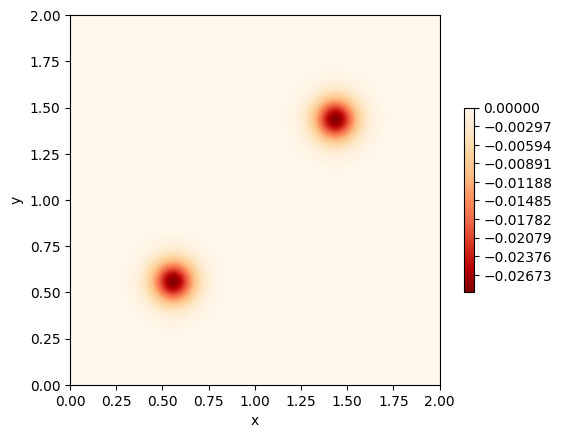

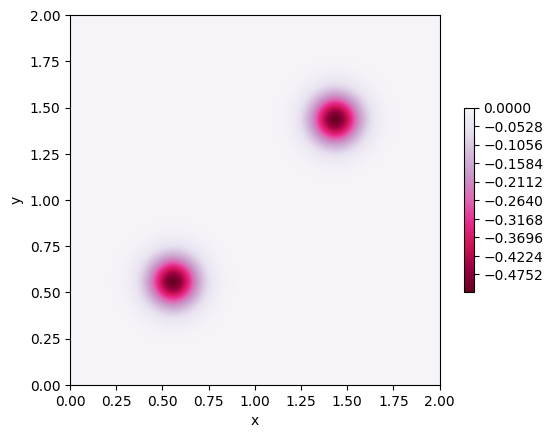

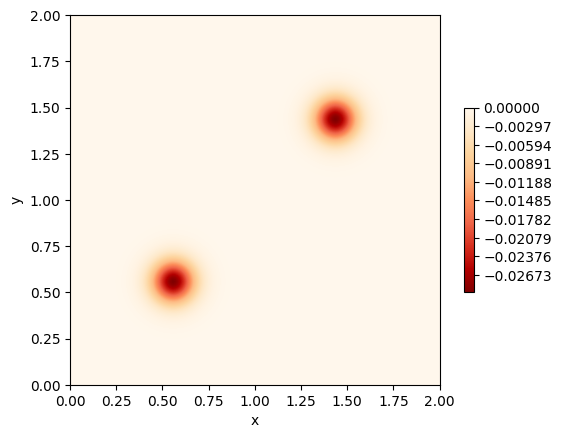

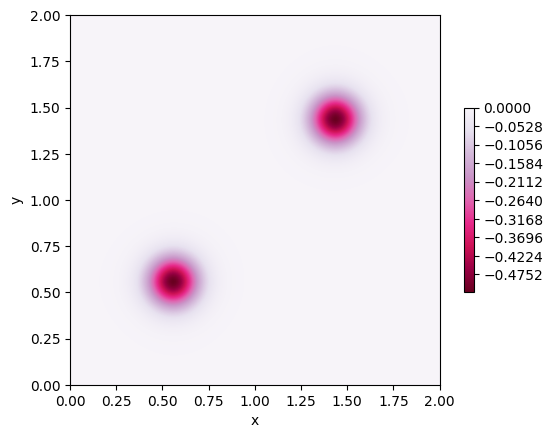

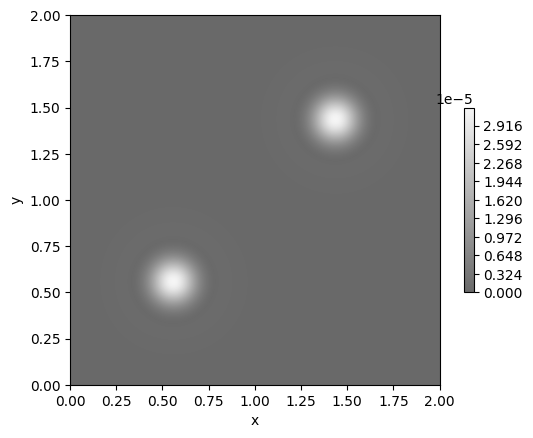

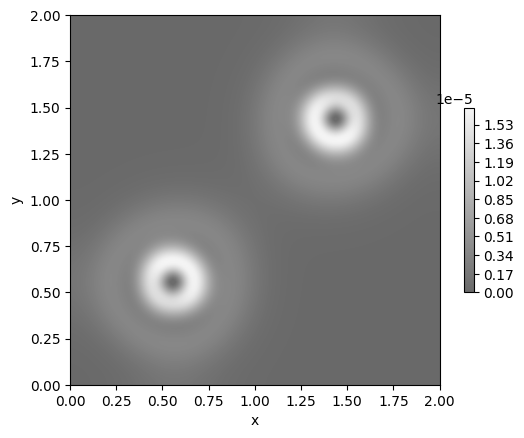

Max diff p 3.231731434797172e-05
Max diff d 1.685905243592467e-05


In [53]:
pres_surface_ref, den_surface_ref, pres_surface_rec, den_surface_rec = (
    pearson_corr_coeff_comp(
        dpres_asymp_mhs1,
        dden_asymp_mhs1,
        dpres_hyp_mhs1,
        dden_hyp_mhs1,
        nresol_x,
        nresol_y,
        nresol_z,
        zmin,
        zmax,
    )
)

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, pres_surface_ref, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs1_fp_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, den_surface_ref, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs1_fd_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, pres_surface_rec, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs1_fp_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, den_surface_rec, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs1_fd_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, abs(pres_surface_rec - pres_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs1_fp_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(y_plot, x_plot, abs(den_surface_rec - den_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(1)
fig.colorbar(cs, shrink=0.5)
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_mhs1_fd_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

error_d = abs(den_surface_rec - den_surface_ref)
error_p = abs(pres_surface_rec - pres_surface_ref)

print("Max diff p", error_p.max())
print("Max diff d", error_d.max())

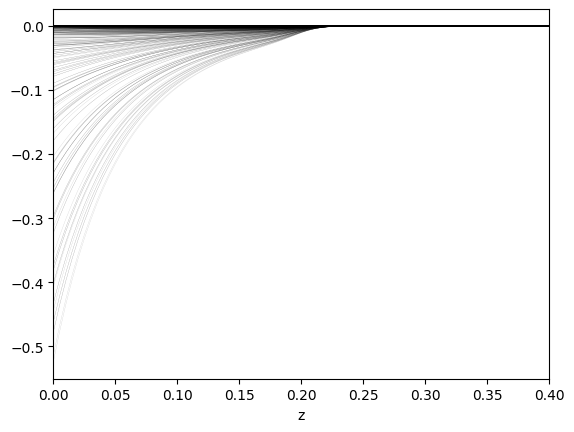

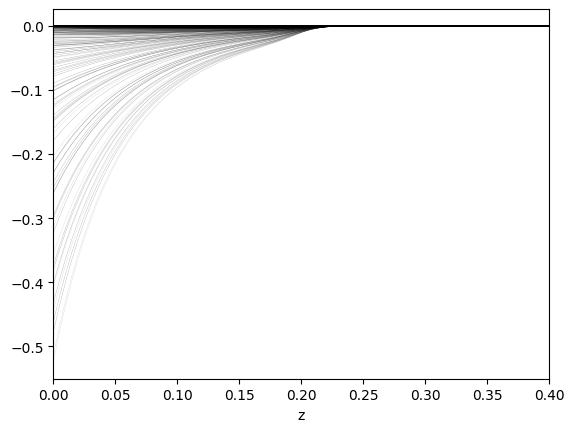

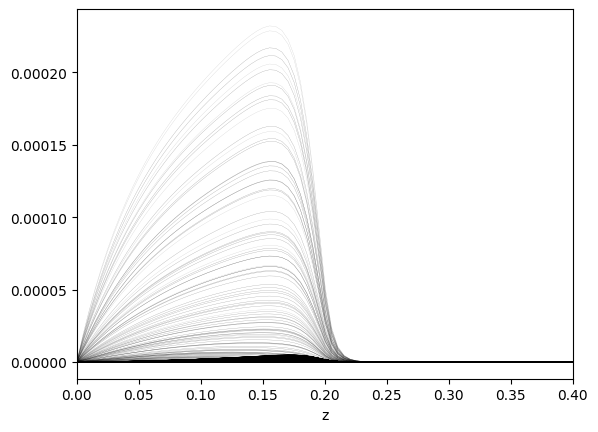

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_6586/1489383890.py:61: RuntimeWarning: invalid value encountered in divide
  abs(dpres_hyp_mhs1[iy, ix, :] - dpres_asymp_mhs1[iy, ix, :])


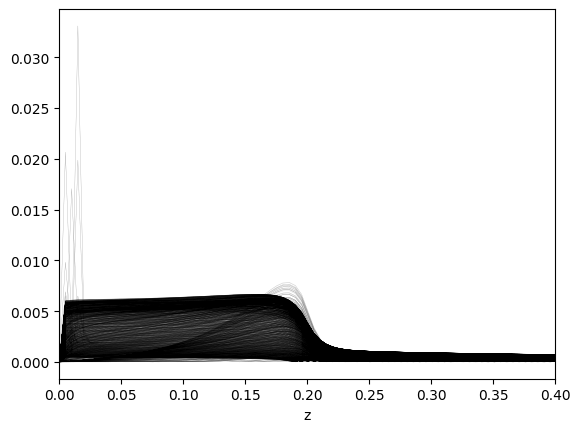

In [54]:
for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dpres_hyp_mhs1[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dphyp_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dpres_asymp_mhs1[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dpasymp_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

"""for ix in range(0, nresol_x, 1):
    for iy in range(0, nresol_y, 1):
        plt.plot(
            z_arr, dpres_low[iy, ix, :], linewidth=0.2, color="black", alpha=0.02
        )
plt.xlim([0, 2*z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dplow_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()"""

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dpres_hyp_mhs1[iy, ix, :] - dpres_asymp_mhs1[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dperr_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dpres_hyp_mhs1[iy, ix, :] - dpres_asymp_mhs1[iy, ix, :])
            / abs(dpres_hyp_mhs1[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dperrrel_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

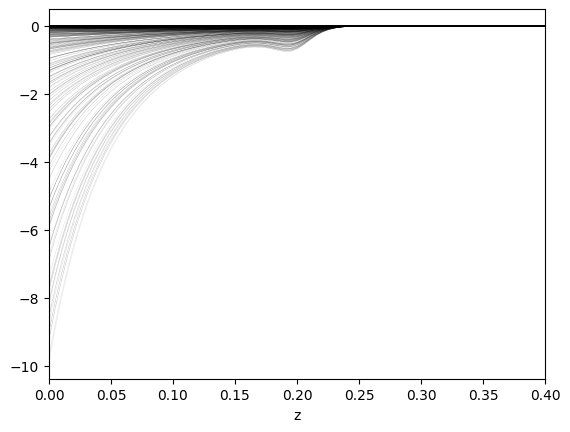

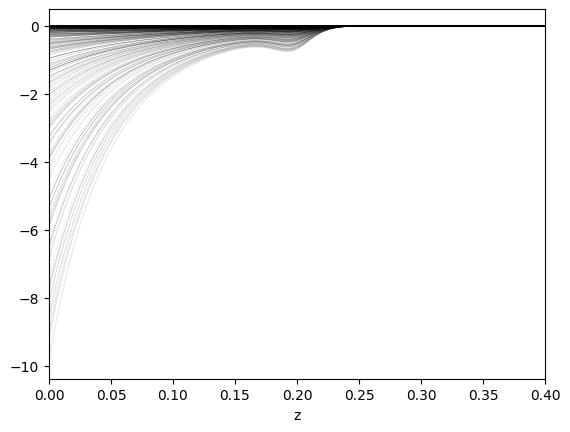

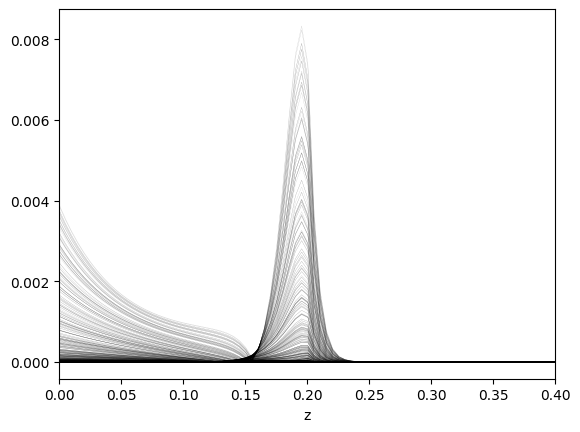

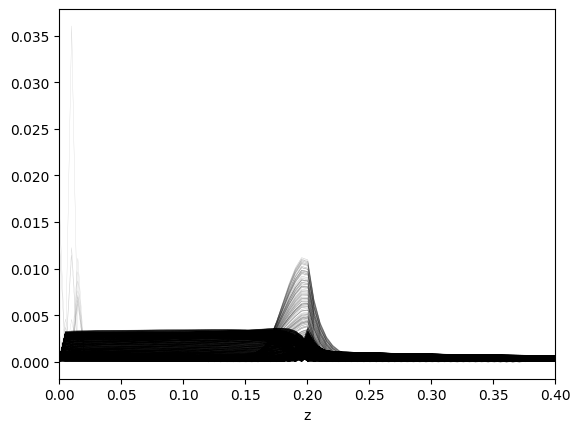

In [55]:
for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dden_hyp_mhs1[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_ddhyp_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            dden_asymp_mhs1[iy, ix, :],
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_ddasymp_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

"""for ix in range(0, nresol_x, 1):
    for iy in range(0, nresol_y, 1):
        plt.plot(
            z_arr, dden_low[iy, ix, :], linewidth=0.2, color="black", alpha=0.02
        )
plt.xlim([0, 2*z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_ddlow_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()"""

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dden_hyp_mhs1[iy, ix, :] - dden_asymp_mhs1[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dderr_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr,
            abs(dden_hyp_mhs1[iy, ix, :] - dden_asymp_mhs1[iy, ix, :])
            / abs(dden_hyp_mhs1[iy, ix, :]),
            linewidth=0.2,
            color="black",
            alpha=0.2,
        )
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dderrrel_mhs1.png"
plt.savefig(plotname, dpi=300)
plt.show()

In [31]:
a = 0.0
alpha = 0.25
b = 1.0

# Magnitc field parameters
z0_b = 0.2
deltaz_b = 0.02
"""a_low = a * (1 - np.tanh(-z0_b / deltaz_b))
kappa = 2.0 / deltaz_b
kappa = -np.log(a/a_low)/z0"""

mfield_hyp, dmfield_hyp = magnetic_field_hypergeo(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)
mfield_asymp, dmfield_asymp = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)

print(
    "Field line",
    field_div_metric(
        mfield_hyp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)
print(
    "Ref",
    field_div_metric(
        mfield_asymp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)

length scale 2.0
length scale x 4.0
length scale y 4.0
length scale x norm 2.0
length scale y norm 2.0
xmin, xmax, ymin, ymax, zmin, zmax  0.0 2.0 0.0 2.0 0.0 2.0


/Users/lilli/Desktop/mflex/mflex/evaluate/metrics.py:395: RuntimeWarning: invalid value encountered in scalar divide
  temp = num / div


Field line 0.990990990990991
Ref 0.990990990990991


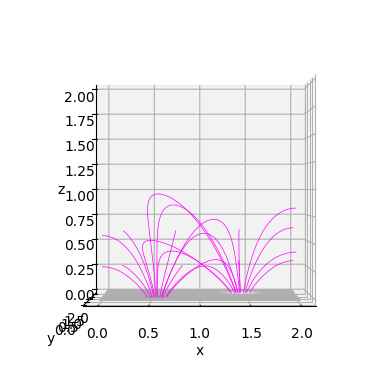

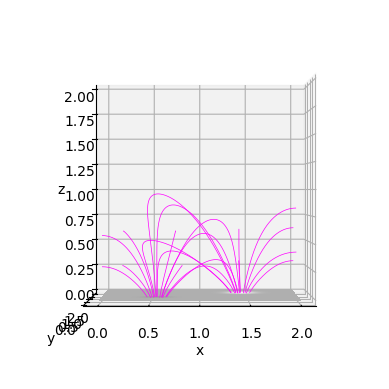

In [56]:
h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

plot_fieldlines_polar_thesis(
    mfield_hyp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_hyp",
    cmap=cmap,
)

plot_fieldlines_polar_thesis(
    mfield_asymp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_asymp",
    cmap=cmap,
)

In [33]:
bfield_bx_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

bfield_bx_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

B_rec = np.array((bfield_by_rec, bfield_bx_rec, bfield_bz_rec))
B_ref = np.array((bfield_by_ref, bfield_bx_ref, bfield_bz_ref))

print("Vec Corr", vec_corr_metric(B_ref, B_rec))
print("Ref", vec_corr_metric(B_ref, B_ref))
print("Vec Corr2", vec_corr_metric2(B_ref, B_rec))
print("Ref", vec_corr_metric2(B_ref, B_ref))
print("Cau Schw", cau_Schw_metric(B_ref, B_rec))
print("Ref", cau_Schw_metric(B_ref, B_ref))
print("Cau Schw2", cau_Schw_metric2(B_ref, B_rec))
print("Ref", cau_Schw_metric2(B_ref, B_ref))
print("Norm err", norm_vec_err_metric(B_ref, B_rec))
print("Ref", norm_vec_err_metric(B_ref, B_ref))
print("Norm err2", norm_vec_err_metric2(B_ref, B_rec))
print("Ref", norm_vec_err_metric2(B_ref, B_ref))
print("Mean err", mean_vec_err_metric(B_ref, B_rec))
print("Ref", mean_vec_err_metric(B_ref, B_ref))
print("Mean err2", mean_vec_err_metric2(B_ref, B_rec))
print("Ref", mean_vec_err_metric2(B_ref, B_ref))
print("Mag ener", mag_ener_metric(B_ref, B_rec))
print("Ref", mag_ener_metric(B_ref, B_ref))
print("Mag ener2", mag_ener_metric2(B_ref, B_rec))
print("Ref", mag_ener_metric2(B_ref, B_ref))

Vec Corr 1.0
Ref 1.0
Vec Corr2 1.0000000000000002
Ref 1.0
Cau Schw 1.0
Ref 1.0
Cau Schw2 1.0
Ref 1.0
Norm err 2.8642864758135084e-16
Ref 0.0
Norm err2 3.035575511196899e-16
Ref 0.0
Mean err 2.916708019571868e-14
Ref 0.0
Mean err2 1.835854567803758e-15
Ref 0.0
Mag ener 1.0000000000000007
Ref 1.0
Mag ener2 0.9999999999999999
Ref 1.0


In [34]:
dpres_hyp_lff = np.zeros((nresol_y, nresol_x, nresol_z))
dpres_asymp_lff = np.zeros((nresol_y, nresol_x, nresol_z))
# dpres_low = np.zeros((nresol_y, nresol_x, nresol_z))

dden_hyp_lff = np.zeros((nresol_y, nresol_x, nresol_z))
dden_asymp_lff = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_low = np.zeros((nresol_y, nresol_x, nresol_z))

for ix in range(nresol_x):
    for iy in range(nresol_y):
        for iz in range(nresol_z):
            z = z_arr[iz]
            bz_hyp = mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            bz_asymp = mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            # bz_low = mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]

            dbz_hyp = (
                dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            dbz_asymp = (
                dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            """dbz_low = (
                dmfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
            )"""

            dpres_hyp_lff[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_hyp)
            dpres_asymp_lff[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_asymp)
            # dpres_low[iy, ix, iz] = deltapres_low(z, kappa, a, bz_low)

            dden_hyp_lff[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_hyp, dbz_hyp
            )
            dden_asymp_lff[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_asymp, dbz_asymp
            )
            # dden_low[iy, ix, iz] = deltaden_low(z, kappa, a, bz_low, dbz_low)

/Users/lilli/Desktop/mflex/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


Pearson Correlation reference value for pressure PearsonRResult(statistic=nan, pvalue=nan)
Pearson Correlation reference value for density PearsonRResult(statistic=nan, pvalue=nan)
Pearson Correlation actual value for pressure PearsonRResult(statistic=nan, pvalue=nan)
Pearson Correlation actual value for density PearsonRResult(statistic=nan, pvalue=nan)


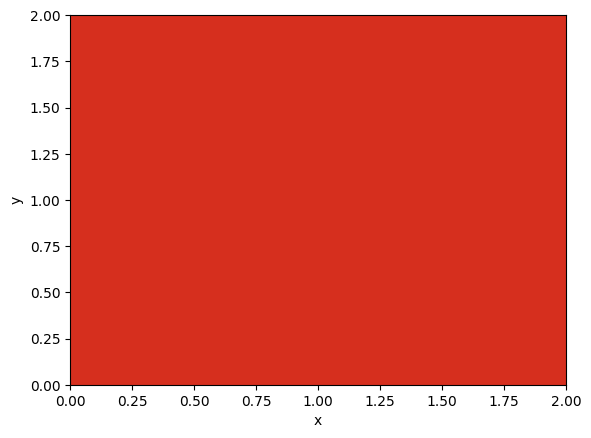

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


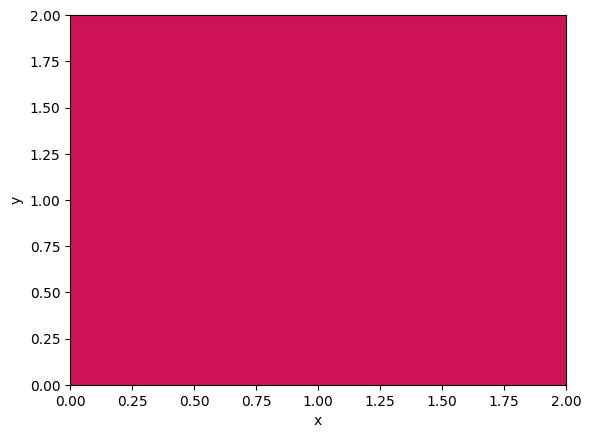

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


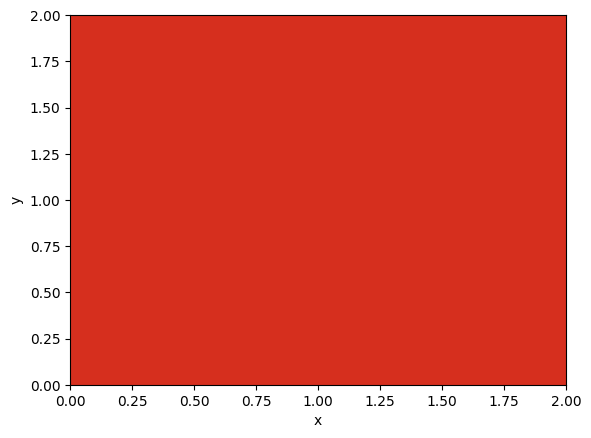

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


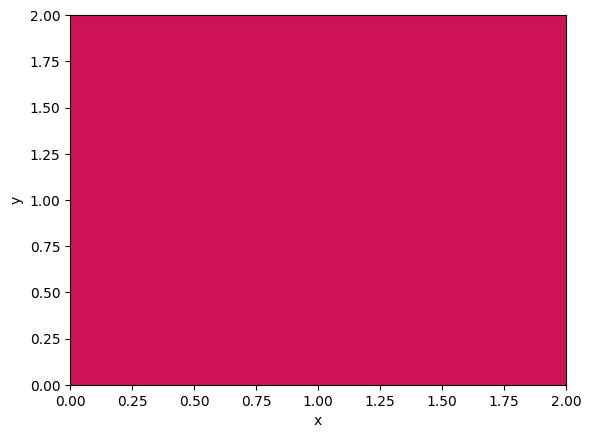

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


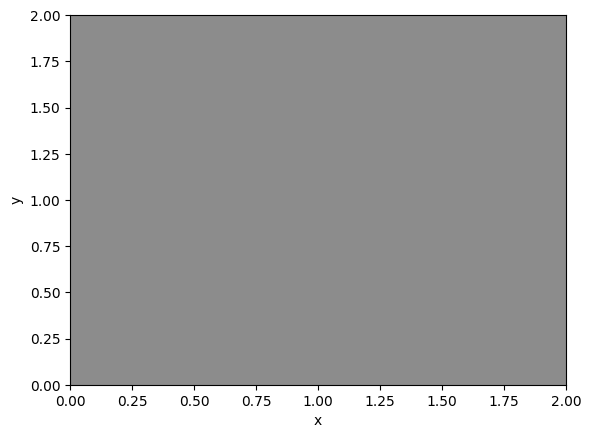

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


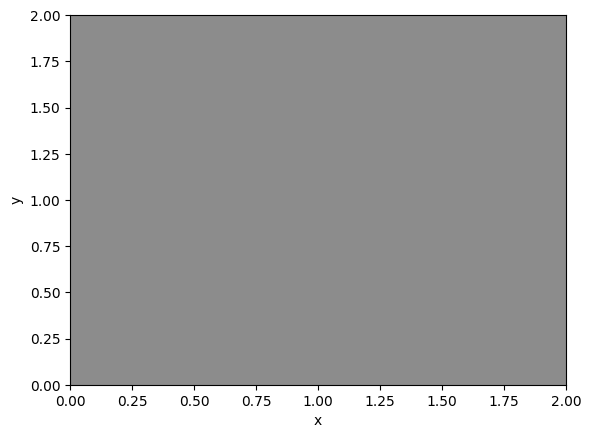

Max diff p 0.0
Max diff d 0.0


In [35]:
pres_surface_ref, den_surface_ref, pres_surface_rec, den_surface_rec = (
    pearson_corr_coeff_comp(
        dpres_asymp_lff,
        dden_asymp_lff,
        dpres_hyp_lff,
        dden_hyp_lff,
        nresol_x,
        nresol_y,
        nresol_z,
        zmin,
        zmax,
    )
)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, pres_surface_ref, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_lff_fp_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, den_surface_ref, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_lff_fd_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, pres_surface_rec, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_lff_fp_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, den_surface_rec, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_lff_fd_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, abs(pres_surface_rec - pres_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_lff_fp_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, abs(den_surface_rec - den_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_lff_fd_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

error_d = abs(den_surface_rec - den_surface_ref)
error_p = abs(pres_surface_rec - pres_surface_ref)

print("Max diff p", error_p.max())
print("Max diff d", error_d.max())

In [36]:
a = 0.0
alpha = 0.0
b = 1.0

# Magnitc field parameters
z0_b = 0.2
deltaz_b = 0.02
"""a_low = a * (1 - np.tanh(-z0_b / deltaz_b))
kappa = 2.0 / deltaz_b
kappa = -np.log(a/a_low)/z0"""

mfield_hyp, dmfield_hyp = magnetic_field_hypergeo(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)
mfield_asymp, dmfield_asymp = magnetic_field(
    data_bz,
    z0_b,
    deltaz_b,
    a,
    b,
    alpha,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    nf_max,
    length_scale,
)

print(
    "Field line",
    field_div_metric(
        mfield_hyp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)
print(
    "Ref",
    field_div_metric(
        mfield_asymp,
        mfield_asymp,
        h1,
        hmin,
        hmax,
        eps,
        nresol_x,
        nresol_y,
        nresol_z,
        -xmax,
        xmax,
        -ymax,
        ymax,
        zmin,
        zmax,
        stepsize=0.1,
    ),
)

length scale 2.0
length scale x 4.0
length scale y 4.0
length scale x norm 2.0
length scale y norm 2.0
xmin, xmax, ymin, ymax, zmin, zmax  0.0 2.0 0.0 2.0 0.0 2.0
Field line 0.9909365558912386
Ref 0.9909365558912386


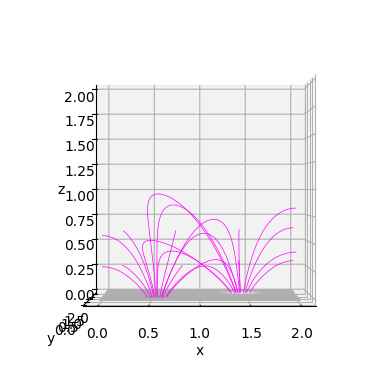

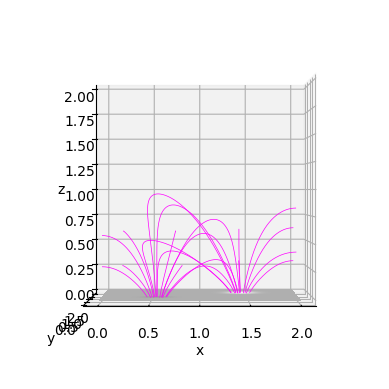

In [57]:
h1 = 0.01  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

plot_fieldlines_polar_thesis(
    mfield_hyp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_hyp",
    cmap=cmap,
)

plot_fieldlines_polar_thesis(
    mfield_asymp,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    nf_max,
    name="Phi_comp_asymp",
    cmap=cmap,
)

In [38]:
bfield_bx_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_rec = mfield_asymp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

bfield_bx_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
bfield_by_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bfield_bz_ref = mfield_hyp[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]

B_rec = np.array((bfield_by_rec, bfield_bx_rec, bfield_bz_rec))
B_ref = np.array((bfield_by_ref, bfield_bx_ref, bfield_bz_ref))

print("Vec Corr", vec_corr_metric(B_ref, B_rec))
print("Ref", vec_corr_metric(B_ref, B_ref))
print("Vec Corr2", vec_corr_metric2(B_ref, B_rec))
print("Ref", vec_corr_metric2(B_ref, B_ref))
print("Cau Schw", cau_Schw_metric(B_ref, B_rec))
print("Ref", cau_Schw_metric(B_ref, B_ref))
print("Cau Schw2", cau_Schw_metric2(B_ref, B_rec))
print("Ref", cau_Schw_metric2(B_ref, B_ref))
print("Norm err", norm_vec_err_metric(B_ref, B_rec))
print("Ref", norm_vec_err_metric(B_ref, B_ref))
print("Norm err2", norm_vec_err_metric2(B_ref, B_rec))
print("Ref", norm_vec_err_metric2(B_ref, B_ref))
print("Mean err", mean_vec_err_metric(B_ref, B_rec))
print("Ref", mean_vec_err_metric(B_ref, B_ref))
print("Mean err2", mean_vec_err_metric2(B_ref, B_rec))
print("Ref", mean_vec_err_metric2(B_ref, B_ref))
print("Mag ener", mag_ener_metric(B_ref, B_rec))
print("Ref", mag_ener_metric(B_ref, B_ref))
print("Mag ener2", mag_ener_metric2(B_ref, B_rec))
print("Ref", mag_ener_metric2(B_ref, B_ref))

Vec Corr 1.0
Ref 1.0
Vec Corr2 1.0
Ref 1.0
Cau Schw 1.0
Ref 1.0
Cau Schw2 1.0
Ref 1.0
Norm err 3.403524619612793e-16
Ref 0.0
Norm err2 3.561741292346521e-16
Ref 0.0
Mean err 7.134896356850041e-14
Ref 0.0
Mean err2 2.115496819365204e-15
Ref 0.0
Mag ener 0.9999999999999998
Ref 1.0
Mag ener2 1.0
Ref 1.0


In [39]:
dpres_hyp_pot = np.zeros((nresol_y, nresol_x, nresol_z))
dpres_asymp_pot = np.zeros((nresol_y, nresol_x, nresol_z))
# dpres_low = np.zeros((nresol_y, nresol_x, nresol_z))

dden_hyp_pot = np.zeros((nresol_y, nresol_x, nresol_z))
dden_asymp_pot = np.zeros((nresol_y, nresol_x, nresol_z))
# dden_low = np.zeros((nresol_y, nresol_x, nresol_z))

for ix in range(nresol_x):
    for iy in range(nresol_y):
        for iz in range(nresol_z):
            z = z_arr[iz]
            bz_hyp = mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            bz_asymp = mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            # bz_low = mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]

            dbz_hyp = (
                dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_hyp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            dbz_asymp = (
                dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_asymp[nresol_y + iy, nresol_x + ix, iz, 2]
            )
            """dbz_low = (
                dmfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 1]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 0]
                + dmfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
                * mfield_low[nresol_y + iy, nresol_x + ix, iz, 2]
            )"""

            dpres_hyp_pot[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_hyp)
            dpres_asymp_pot[iy, ix, iz] = deltapres(z, z0_b, deltaz_b, a, b, bz_asymp)
            # dpres_low[iy, ix, iz] = deltapres_low(z, kappa, a, bz_low)

            dden_hyp_pot[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_hyp, dbz_hyp
            )
            dden_asymp_pot[iy, ix, iz] = deltaden(
                z, z0_b, deltaz_b, a, b, bz_asymp, dbz_asymp
            )
            # dden_low[iy, ix, iz] = deltaden_low(z, kappa, a, bz_low, dbz_low)

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


Pearson Correlation reference value for pressure PearsonRResult(statistic=nan, pvalue=nan)
Pearson Correlation reference value for density PearsonRResult(statistic=nan, pvalue=nan)
Pearson Correlation actual value for pressure PearsonRResult(statistic=nan, pvalue=nan)
Pearson Correlation actual value for density PearsonRResult(statistic=nan, pvalue=nan)


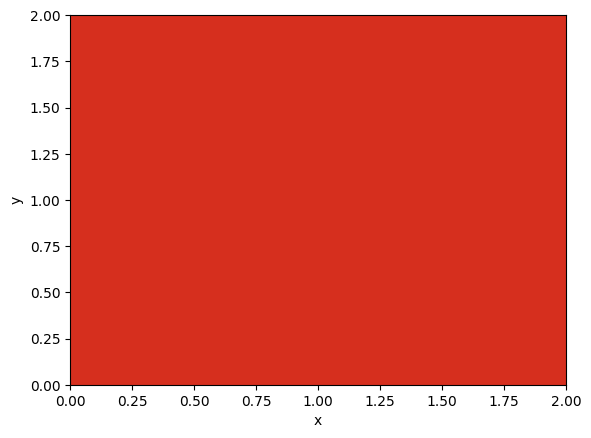

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


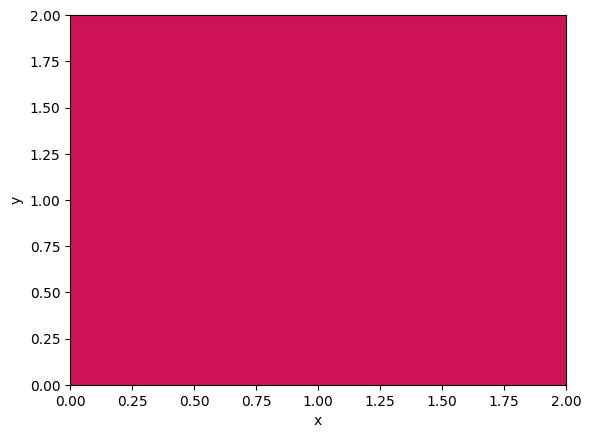

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


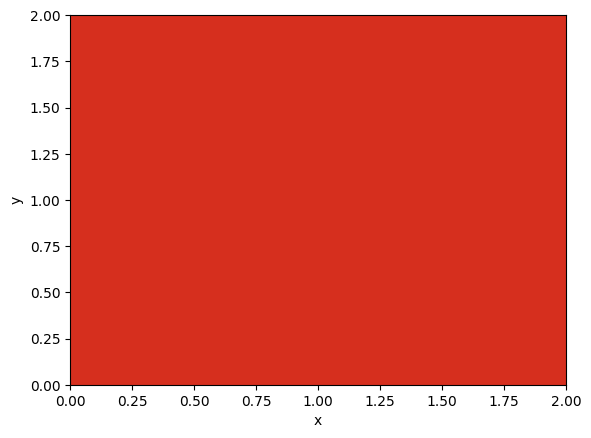

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


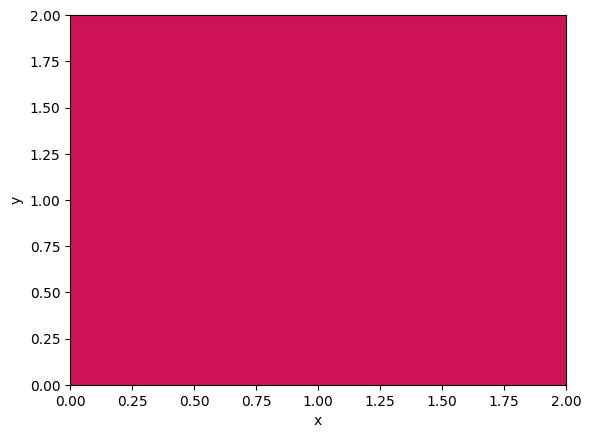

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


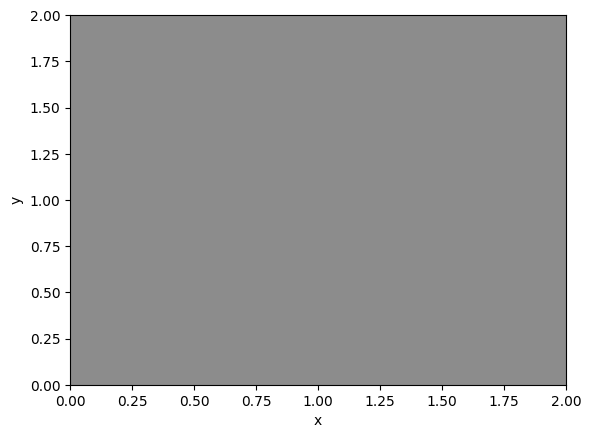

Locator attempting to generate 1001 ticks ([-9.999999999999999e-14, ..., 1e-13]), which exceeds Locator.MAXTICKS (1000).


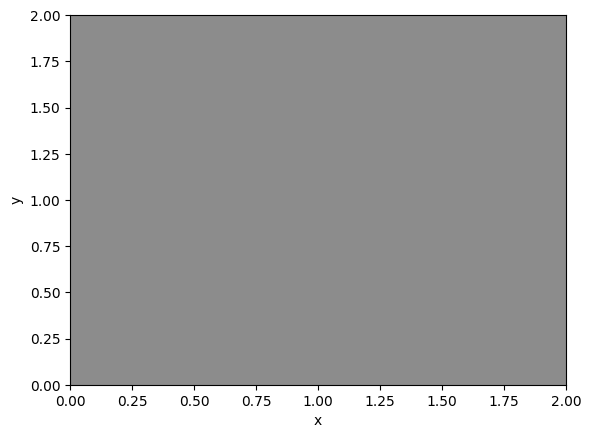

Max diff p 0.0
Max diff d 0.0


In [40]:
pres_surface_ref, den_surface_ref, pres_surface_rec, den_surface_rec = (
    pearson_corr_coeff_comp(
        dpres_asymp_pot,
        dden_asymp_pot,
        dpres_hyp_pot,
        dden_hyp_pot,
        nresol_x,
        nresol_y,
        nresol_z,
        zmin,
        zmax,
    )
)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, pres_surface_ref, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_pot_fp_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, den_surface_ref, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_pot_fd_ref_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, pres_surface_rec, 1000, cmap="OrRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_pot_fp_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, den_surface_rec, 1000, cmap="PuRd_r")
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_pot_fd_rec_los.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, abs(pres_surface_rec - pres_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_pot_fp_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(y_plot, x_plot, abs(den_surface_rec - den_surface_ref), 1000, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = "/Users/lilli/Desktop/mflex/seminar2024/solcomp_pot_fd_los_error.png"
plt.savefig(plotname, dpi=300)
plt.show()

error_d = abs(den_surface_rec - den_surface_ref)
error_p = abs(pres_surface_rec - pres_surface_ref)

print("Max diff p", error_p.max())
print("Max diff d", error_d.max())

(143, 143)
(143, 143, 0)
(143, 143, 0)


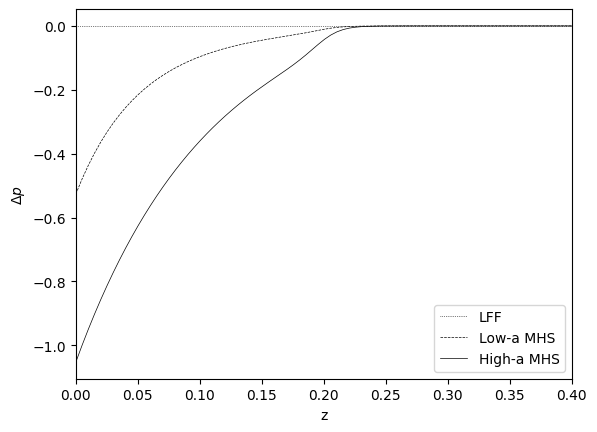

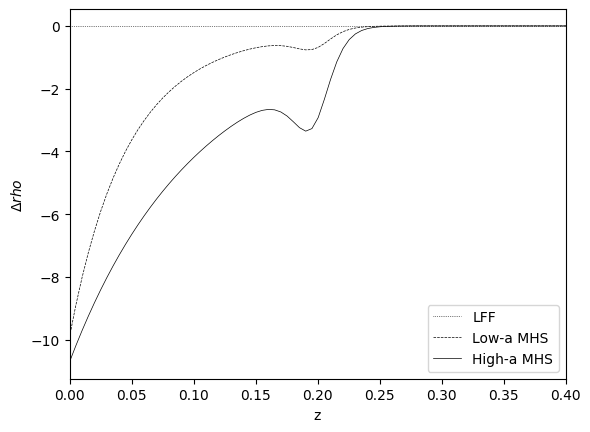

In [58]:
print(np.unravel_index(data_bz.argmax(), data_bz.shape))
print(np.unravel_index(dpres_asymp_mhs2.argmin(), dpres_asymp_mhs2.shape))
print(np.unravel_index(dden_asymp_mhs2.argmin(), dden_asymp_mhs2.shape))
backpres = 0.0 * z_arr
backden = 0.0 * z_arr

for iz in range(nresol_z):
    z = z_arr[iz]
    backpres[iz] = bpressure(z, z0, deltaz, h, t0, t1)
    backden[iz] = bdensity(z, z0, deltaz, h, t0, t1)

plt.plot(
    z_arr,
    dpres_asymp_lff[143, 143, :],
    linewidth=0.5,
    linestyle="dotted",
    color="black",
    label="LFF",
)
plt.plot(
    z_arr,
    dpres_asymp_mhs1[143, 143, :],
    linewidth=0.5,
    linestyle="dashed",
    color="black",
    label="Low-a MHS",
)
plt.plot(
    z_arr,
    dpres_asymp_mhs2[143, 143, :],
    linewidth=0.5,
    linestyle="solid",
    color="black",
    label="High-a MHS",
)
plt.xlim([0, 2 * z0])
plt.ylabel("$\Delta p$")
plt.xlabel("z")
plt.legend()
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dpres_all.png"
plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr,
    dden_asymp_lff[143, 143, :],
    linewidth=0.5,
    linestyle="dotted",
    color="black",
    label="LFF",
)
plt.plot(
    z_arr,
    dden_asymp_mhs1[143, 143, :],
    linewidth=0.5,
    linestyle="dashed",
    color="black",
    label="Low-a MHS",
)
plt.plot(
    z_arr,
    dden_asymp_mhs2[143, 143, :],
    linewidth=0.5,
    linestyle="solid",
    color="black",
    label="High-a MHS",
)
plt.xlim([0, 2 * z0])
plt.ylabel("$\Delta rho $")
plt.xlabel("z")
plt.legend()
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_dden_all.png"
plt.savefig(plotname, dpi=300)
plt.show()

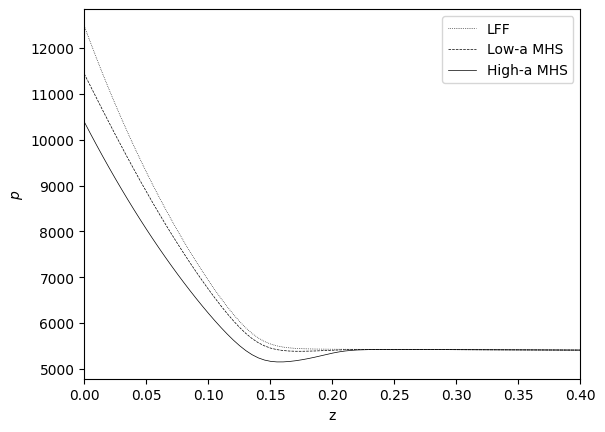

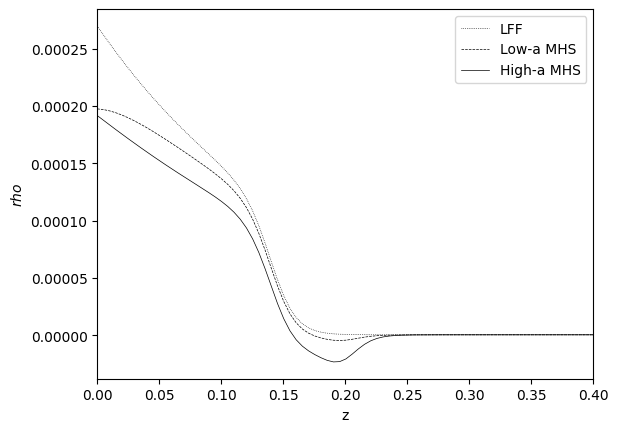

In [59]:
plt.plot(
    z_arr,
    b0**2.0 / mu0 * 10**-8 * (0.5 * beta0 * backpres[:] + dpres_asymp_lff[143, 143, :] ),
    linewidth=0.5,
    linestyle="dotted",
    color="black",
    label="LFF",
)
plt.plot(
    z_arr,
    b0**2.0 / mu0 * 10**-8 * (0.5 * beta0 * backpres[:] + dpres_asymp_mhs1[143, 143, :]),
    linewidth=0.5,
    linestyle="dashed",
    color="black",
    label="Low-a MHS",
)
plt.plot(
    z_arr,
    b0**2.0 / mu0 * 10**-8 * (0.5 * beta0 * backpres[:] + dpres_asymp_mhs2[143, 143, :]),
    linewidth=0.5,
    linestyle="solid",
    color="black",
    label="High-a MHS",
)
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plt.ylabel("$p$")
plt.legend()
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_fpres_all_norm.png"
plt.savefig(plotname, dpi=300)
plt.show()

plt.plot(
    z_arr, b0**2.0* 10**-14/ (mu0 * g_solar * L) * ( 0.5 * beta0 / h * t0 / t_photosphere * backden[:] + dden_asymp_lff[143, 143, :]),
    linewidth=0.5,
    linestyle="dotted",
    color="black",
    label="LFF",
)
plt.plot(
    z_arr,b0**2.0* 10**-14/ (mu0 * g_solar * L) * ( 0.5 * beta0 / h * t0 / t_photosphere * backden[:] + dden_asymp_mhs1[143, 143, :]),
    linewidth=0.5,
    linestyle="dashed",
    color="black",
    label="Low-a MHS",
)
plt.plot(
    z_arr, b0**2.0* 10**-14/ (mu0 * g_solar * L) * ( 0.5 * beta0 / h * t0 / t_photosphere * backden[:] + dden_asymp_mhs2[143, 143, :]),
    linewidth=0.5,
    linestyle="solid",
    color="black",
    label="High-a MHS",
)
plt.xlim([0, 2 * z0])
plt.xlabel("z")
plt.ylabel("$rho$")
plt.legend()
plotname = "/Users/lilli/Desktop/Thesis_vonNeu/solcomp_fden_all_norm.png"
plt.savefig(plotname, dpi=300)
plt.show()

In [43]:
test = 0.5 * beta0 / h * t0 / t_photosphere * backden[:] + dden_asymp_lff[143, 143, :]

In [44]:
print(test.min())

0.04367339544473271
